## POS tagging using modified Viterbi

### Objective

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 

- Solve the problem of unknown words using at least two techniques. 

- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.

- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after our modifications.

In [1]:
## Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
## nltk.download('universal_tagset')

## Data Preparation

In [2]:
## nltk.download('treebank')

#### Reading the Treebank tagged sentences

In [3]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
type(nltk_data)

list

#### Tagged sentences

In [4]:
print(nltk_data[::])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

#### POS tags

In [5]:
tags=[x[0][1] for x in nltk_data]
print(tags[0:50])

['NOUN', 'NOUN', 'NOUN', 'DET', 'DET', 'NOUN', 'ADP', 'DET', 'PRON', 'DET', 'DET', '.', 'NOUN', 'DET', 'ADP', 'ADP', 'NUM', 'DET', '.', 'DET', 'DET', 'DET', 'DET', 'ADV', 'ADP', 'ADP', 'ADP', 'NOUN', 'NOUN', 'NOUN', '.', '.', 'PRON', 'NOUN', 'DET', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'DET', 'ADV', 'DET', 'ADP', 'NOUN', 'ADV', 'DET', 'NOUN', 'PRON', 'DET', 'DET']


In [6]:
## Further checking for the distinct tags
unique_tags = set(tags)
print(list(unique_tags))

['ADJ', '.', 'NOUN', 'PRT', 'ADV', 'CONJ', 'PRON', 'DET', 'VERB', 'ADP', 'NUM', 'X']


#### Splitting into train and test

In [7]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)


In [8]:
## Summary of the train and test dataset
print("Training Set Length -", len(train_set))
print("Training Set Length -", len(test_set))
print("Training Data at a glance -\n")
print(train_set[:15])

Training Set Length - 3718
Training Set Length - 196
Training Data at a glance -

[[('The', 'DET'), ('two', 'NUM'), ('concerns', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('entered', 'VERB'), ('into', 'ADP'), ('a', 'DET'), ('definitive', 'ADJ'), ('merger', 'NOUN'), ('agreement', 'NOUN'), ('under', 'ADP'), ('which', 'DET'), ('Ratners', 'NOUN'), ('will', 'VERB'), ('begin', 'VERB'), ('a', 'DET'), ('tender', 'NOUN'), ('offer', 'NOUN'), ('for', 'ADP'), ('all', 'DET'), ('of', 'ADP'), ('Weisfield', 'NOUN'), ("'s", 'PRT'), ('common', 'ADJ'), ('shares', 'NOUN'), ('for', 'ADP'), ('$', '.'), ('57.50', 'NUM'), ('*U*', 'X'), ('each', 'DET'), ('*T*-1', 'X'), ('.', '.')], [('you', 'PRON'), ('will', 'VERB'), ('not', 'ADV'), ('put', 'VERB'), ('the', 'DET'), ('financial', 'ADJ'), ('system', 'NOUN'), ('in', 'ADP'), ('jeopardy', 'NOUN'), ('.', '.'), ("'", '.'), ("''", '.')], [('In', 'ADP'), ('*', 'X'), ('quoting', 'VERB'), ('from', 'ADP'), ('our', 'PRON'), ('research', 'NOUN'), ('you', 'PRO

#### Getting list of tagged words

In [9]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95711

In [10]:
## Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('The', 'DET'),
 ('two', 'NUM'),
 ('concerns', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('they', 'PRON'),
 ('entered', 'VERB'),
 ('into', 'ADP'),
 ('a', 'DET'),
 ('definitive', 'ADJ')]

In [11]:
## tokens in the train set - train_tagged_words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['The',
 'two',
 'concerns',
 'said',
 '0',
 'they',
 'entered',
 'into',
 'a',
 'definitive']

In [12]:
## POS tags for the tokens in the train set -
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['DET', 'NUM', 'NOUN', 'VERB', 'X', 'PRON', 'VERB', 'ADP', 'DET', 'ADJ']

In [13]:
## building the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

In [14]:
## building the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)

#### Summary

In [15]:

print("Length : \nVocabulary: {} \nTags: {}".format(len(training_vocabulary_set), len(training_pos_tag_set)))
print("\nAvailable Tags :\n")
print(training_pos_tag_set)

Length : 
Vocabulary: 12114 
Tags: 12

Available Tags :

{'ADJ', 'PRT', 'NOUN', '.', 'ADV', 'CONJ', 'PRON', 'DET', 'VERB', 'ADP', 'NUM', 'X'}


## POS Tagging algorithm using Hidden Markov Model (HMM)

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. In other words, to every word w, assign the tag t that maximises the likelihood P(t/w).

Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

Now:

- P(w/t): is the **emission probability** of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: P(w/t) = count(w, t) / count(t).

- P(t): is the probability of tag (also **transition probability**), and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


#### Emission Probabilities

**computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension of len(training_pos_tag_set) X en(training_vocabulary_set)**

In [16]:
len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [17]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities

**compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability**

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# steps-
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Let's have a look into the transition matrix
tags_matrix

array([[6.58348352e-02, 1.06714824e-02, 6.99885070e-01, 6.58348352e-02,
        4.43276949e-03, 1.72385480e-02, 6.56706630e-04, 4.92529944e-03,
        1.16565423e-02, 7.76555538e-02, 2.01937277e-02, 2.10146122e-02],
       [8.54896829e-02, 1.96528016e-03, 2.45332465e-01, 4.42188010e-02,
        9.49885324e-03, 2.29282677e-03, 1.80150680e-02, 1.02194563e-01,
        4.00262028e-01, 2.09629871e-02, 5.66655733e-02, 1.31018674e-02],
       [1.19494339e-02, 4.36810069e-02, 2.64526933e-01, 2.40555212e-01,
        1.69405080e-02, 4.24787775e-02, 4.62676259e-03, 1.34066818e-02,
        1.47182047e-01, 1.76327005e-01, 9.28995572e-03, 2.90356670e-02],
       [4.42589112e-02, 2.51369062e-03, 2.22820714e-01, 9.34554264e-02,
        5.25181778e-02, 5.80842085e-02, 6.54457286e-02, 1.72995776e-01,
        8.83382708e-02, 9.09417346e-02, 8.11562985e-02, 2.73812730e-02],
       [1.28850609e-01, 1.49055980e-02, 3.14673744e-02, 1.34812847e-01,
        7.94965252e-02, 6.95594586e-03, 1.52368331e-02, 6.95

In [20]:
# convert the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# Let's have a look at the dataset
tags_df

ADJ       PRT      NOUN         .       ADV      CONJ      PRON  \
ADJ   0.065835  0.010671  0.699885  0.065835  0.004433  0.017239  0.000657   
PRT   0.085490  0.001965  0.245332  0.044219  0.009499  0.002293  0.018015   
NOUN  0.011949  0.043681  0.264527  0.240555  0.016941  0.042479  0.004627   
.     0.044259  0.002514  0.222821  0.093455  0.052518  0.058084  0.065446   
ADV   0.128851  0.014906  0.031467  0.134813  0.079497  0.006956  0.015237   
CONJ  0.117975  0.004645  0.346958  0.033906  0.055272  0.000464  0.059452   
PRON  0.072145  0.011574  0.209105  0.039352  0.034336  0.005015  0.007330   
DET   0.206233  0.000241  0.638190  0.017687  0.012514  0.000602  0.003489   
VERB  0.065364  0.031790  0.109871  0.034504  0.082655  0.005350  0.035745   
ADP   0.106605  0.001387  0.321737  0.040230  0.013339  0.000854  0.068296   
NUM   0.034751  0.025764  0.355902  0.111144  0.002696  0.013481  0.001498   
X     0.016831  0.184027  0.061289  0.164655  0.025564  0.010480  0.055414   

           DET      VERB       ADP       NUM         X  
ADJ   0.004925  0.011657  0.077656  0.020194  0.021015  
PRT   0.102195  0.400262  0.020963  0.056666  0.013102  
NOUN  0.013407  0.147182  0.176327  0.009290  0.029036  
.     0.172996  0.088338  0.090942  0.081156  0.027381  
ADV   0.069559  0.346141  0.118914  0.029811  0.023849  
CONJ  0.121226  0.156990  0.052485  0.041802  0.008825  
PRON  0.009645  0.488426  0.023148  0.007330  0.092593  
DET   0.005655  0.038383  0.009265  0.021899  0.045843  
VERB  0.134140  0.169032  0.091494  0.022563  0.217492  
ADP   0.325259  0.008430  0.017287  0.061680  0.034895  
NUM   0.003295  0.017675  0.036549  0.184242  0.213002  
X     0.054144  0.205462  0.144173  0.002858  0.075103

In [21]:
tags_df.loc['.', :]

ADJ     0.044259
PRT     0.002514
NOUN    0.222821
.       0.093455
ADV     0.052518
CONJ    0.058084
PRON    0.065446
DET     0.172996
VERB    0.088338
ADP     0.090942
NUM     0.081156
X       0.027381
Name: ., dtype: float32

## Exploratory Data Analysis

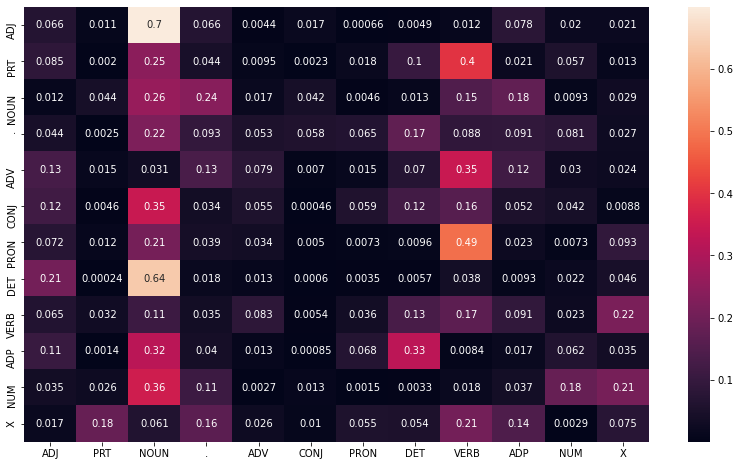

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

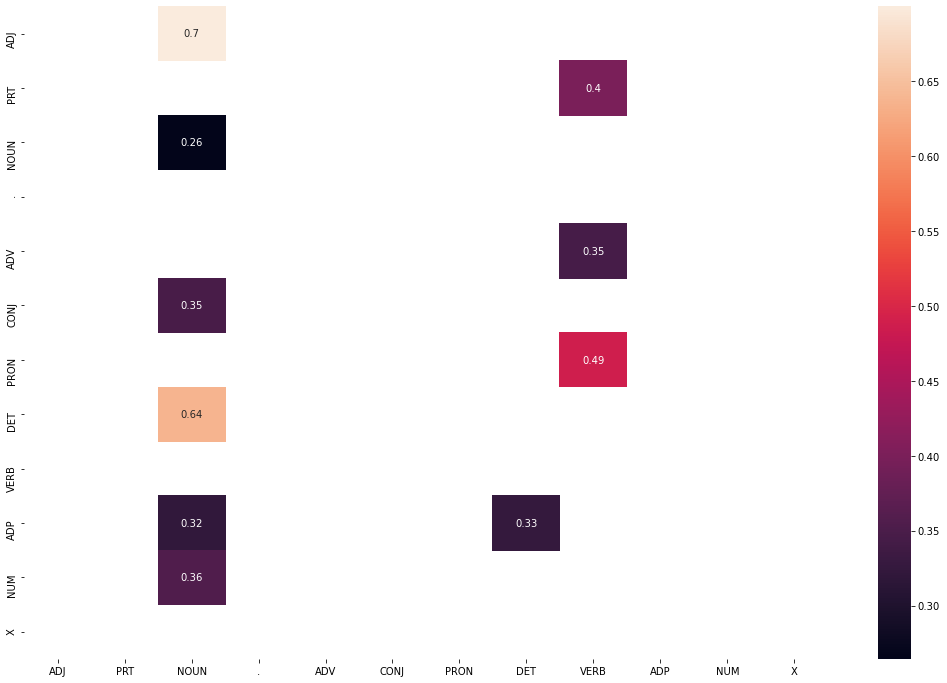

In [23]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot=True)
plt.show()

In [24]:
len(train_tagged_words)

95711

## Build the vanilla Viterbi based POS tagger


#### Viterbi Algorithm

The steps are as follows:
- Given a sequence of words
- iterate through the sequence
- for each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
- assign the tag which has maximum probability obtained in step 3 above.
- move to the next word in sequence to repeat steps 3 and 4 above.



In [25]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


#### Testing Vanilla Viterbi Algorithm on sampled test data

In [26]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('More', 'ADV'),
  ('often', 'ADV'),
  ('than', 'ADP'),
  ('not', 'ADV'),
  (',', '.'),
  ('ringers', 'NOUN'),
  ('think', 'VERB'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('church', 'NOUN'),
  ('as', 'ADP'),
  ('something', 'NOUN'),
  ('stuck', 'VERB'),
  ('*', 'X'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('bottom', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('belfry', 'NOUN'),
  ('.', '.')],
 [('Its', 'PRON'),
  ('1989-90', 'NUM'),
  ('exports', 'NOUN'),
  ('were', 'VERB'),
  ('expected', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('total', 'VERB'),
  ('645,000', 'NUM'),
  ('tons', 'NOUN'),
  ('in', 'ADP'),
  ('contrast', 'NOUN'),
  ('to', 'PRT'),
  ('shipments', 'NOUN'),
  ('of', 'ADP'),
  ('1.5', 'NUM'),
  ('million', 'NUM'),
  ('tons', 'NOUN'),
  ('in', 'ADP')],
 [('Rep.', 'NOUN'),
  ('Jerry', 'NOUN'),
  ('Lewis', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('conservative', 'ADJ'),
  ('Californian', 'NOUN'),
  (',', '.'),
  ('added', 'VERB'),
  ('a', 'DET'),
  ('provision', 'NOUN'),

In [27]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  54.35993456840515
[('More', 'ADJ'), ('often', 'ADV'), ('than', 'ADP'), ('not', 'ADV'), (',', '.'), ('ringers', 'NOUN'), ('think', 'VERB'), ('of', 'ADP'), ('the', 'DET'), ('church', 'NOUN'), ('as', 'ADP'), ('something', 'NOUN'), ('stuck', 'ADJ'), ('*', 'X'), ('on', 'ADP'), ('the', 'DET'), ('bottom', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('belfry', 'NOUN'), ('.', '.'), ('Its', 'PRON'), ('1989-90', 'NUM'), ('exports', 'NOUN'), ('were', 'VERB'), ('expected', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('total', 'ADJ'), ('645,000', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('contrast', 'VERB'), ('to', 'PRT'), ('shipments', 'NOUN'), ('of', 'ADP'), ('1.5', 'NUM'), ('million', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('Rep.', 'NOUN'), ('Jerry', 'NOUN'), ('Lewis', 'NOUN'), (',', '.'), ('a', 'DET'), ('conservative', 'ADJ'), ('Californian', 'ADJ'), (',', '.'), ('added', 'VERB'), ('a', 'DET'), ('provision', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('own', 'ADJ'), ('intended', 'V

In [28]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

print("The accuracy of the Vanilla Viterbi Algorithm is -", vannila_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.8920454545454546


In [29]:
# let's check the incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

19


[[('.', '.'), (('More', 'ADJ'), ('More', 'ADV'))],
 [('something', 'NOUN'), (('stuck', 'ADJ'), ('stuck', 'VERB'))],
 [('to', 'PRT'), (('total', 'ADJ'), ('total', 'VERB'))],
 [('in', 'ADP'), (('contrast', 'VERB'), ('contrast', 'NOUN'))],
 [('conservative', 'ADJ'), (('Californian', 'ADJ'), ('Californian', 'NOUN'))],
 [('assist', 'VERB'), (('Bolivia', 'ADJ'), ('Bolivia', 'NOUN'))],
 [('then', 'ADV'), (('broadened', 'ADJ'), ('broadened', 'VERB'))],
 [('Basin', 'NOUN'), (('initiate', 'ADJ'), ('initiate', 'NOUN'))],
 [('initiate', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('powerful', 'ADJ'), (('Hawaii', 'ADJ'), ('Hawaii', 'NOUN'))],
 [('.', '.'), (('First', 'NOUN'), ('First', 'ADJ'))],
 [('of', 'ADP'), (('prepayment', 'ADJ'), ('prepayment', 'NOUN'))],
 [('rates', 'NOUN'), (('decline', 'NOUN'), ('decline', 'VERB'))],
 [('such', 'ADJ'), (('prepayment', 'ADJ'), ('prepayment', 'NOUN'))],
 [('prepayment', 'NOUN'), (('forces', 'NOUN'), ('forces', 'VERB'))],
 [('to', 'PRT'), (('redeploy', 'ADJ')

In [30]:
## nltk.download('punkt')
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start


In [31]:
print(tagged_seq)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [32]:
print(difference)
vannila_test_tagged_seq = tagged_seq

51.80972385406494


In [33]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 11


Unknown Words : ['broadened', 'Hawaii', 'Zicklin', 'Bolivia', 'prepayment', 'initiate', 'Californian', 'stuck', 'frightened', 'redeploy', 'lotter']


### Solve the problem of unknown words

#### Version 1 : Lexicon Based Tagging with Viterbi

**First solution for unknown words:** 
-  we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

In [34]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('ADJ', 0.06363949807232189),
 ('PRT', 0.03189810993511718),
 ('NOUN', 0.2867904420599513),
 ('.', 0.11638160712979699),
 ('ADV', 0.03154287385984892),
 ('CONJ', 0.022494802060369235),
 ('PRON', 0.027081526679274066),
 ('DET', 0.0868343241633668),
 ('VERB', 0.13474940184513798),
 ('ADP', 0.0979093312158477),
 ('NUM', 0.034875824095454026),
 ('X', 0.06580225888351392)]

In [35]:

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [36]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))



In [37]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  54.88005065917969
[('More', 'ADJ'), ('often', 'ADV'), ('than', 'ADP'), ('not', 'ADV'), (',', '.'), ('ringers', 'NOUN'), ('think', 'VERB'), ('of', 'ADP'), ('the', 'DET'), ('church', 'NOUN'), ('as', 'ADP'), ('something', 'NOUN'), ('stuck', 'NOUN'), ('*', 'X'), ('on', 'ADP'), ('the', 'DET'), ('bottom', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('belfry', 'NOUN'), ('.', '.'), ('Its', 'PRON'), ('1989-90', 'NUM'), ('exports', 'NOUN'), ('were', 'VERB'), ('expected', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('total', 'ADJ'), ('645,000', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('contrast', 'VERB'), ('to', 'PRT'), ('shipments', 'NOUN'), ('of', 'ADP'), ('1.5', 'NUM'), ('million', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('Rep.', 'NOUN'), ('Jerry', 'NOUN'), ('Lewis', 'NOUN'), (',', '.'), ('a', 'DET'), ('conservative', 'ADJ'), ('Californian', 'NOUN'), (',', '.'), ('added', 'VERB'), ('a', 'DET'), ('provision', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('own', 'ADJ'), ('intended', 

In [38]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9431818181818182


[[('.', '.'), (('More', 'ADJ'), ('More', 'ADV'))],
 [('something', 'NOUN'), (('stuck', 'NOUN'), ('stuck', 'VERB'))],
 [('to', 'PRT'), (('total', 'ADJ'), ('total', 'VERB'))],
 [('in', 'ADP'), (('contrast', 'VERB'), ('contrast', 'NOUN'))],
 [('initiate', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('.', '.'), (('First', 'NOUN'), ('First', 'ADJ'))],
 [('rates', 'NOUN'), (('decline', 'NOUN'), ('decline', 'VERB'))],
 [('prepayment', 'NOUN'), (('forces', 'NOUN'), ('forces', 'VERB'))],
 [('to', 'PRT'), (('redeploy', 'NOUN'), ('redeploy', 'VERB'))],
 [('becomes', 'VERB'), (('frightened', 'NOUN'), ('frightened', 'VERB'))]]

In [39]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

#### Version 2 : Rule Based Tagging with Viterbi

#### Second solution for unknown words:
- backoff to rule based tagger in case of unknown words.
- we further observe that POS tag 'X' can be easily encapsulated in regex rule, so we extract it only based on ruled based tagged.
- if word does not fall in any rule, to correct this let's assign the tags for any such word based purely on transition probability of tags.

Let's define a rule based tagger as below:


In [40]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)


In [41]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))



In [42]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  56.430017948150635
[('More', 'ADJ'), ('often', 'ADV'), ('than', 'ADP'), ('not', 'ADV'), (',', '.'), ('ringers', 'NOUN'), ('think', 'VERB'), ('of', 'ADP'), ('the', 'DET'), ('church', 'NOUN'), ('as', 'ADP'), ('something', 'NOUN'), ('stuck', 'NOUN'), ('*', 'X'), ('on', 'ADP'), ('the', 'DET'), ('bottom', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('belfry', 'NOUN'), ('.', '.'), ('Its', 'PRON'), ('1989-90', 'NUM'), ('exports', 'NOUN'), ('were', 'VERB'), ('expected', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('total', 'ADJ'), ('645,000', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('contrast', 'VERB'), ('to', 'PRT'), ('shipments', 'NOUN'), ('of', 'ADP'), ('1.5', 'NUM'), ('million', 'NUM'), ('tons', 'NOUN'), ('in', 'ADP'), ('Rep.', 'NOUN'), ('Jerry', 'NOUN'), ('Lewis', 'NOUN'), (',', '.'), ('a', 'DET'), ('conservative', 'ADJ'), ('Californian', 'NOUN'), (',', '.'), ('added', 'VERB'), ('a', 'DET'), ('provision', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('own', 'ADJ'), ('intended',

In [43]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9488636363636364


In [44]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('More', 'ADJ'), ('More', 'ADV'))],
 [('something', 'NOUN'), (('stuck', 'NOUN'), ('stuck', 'VERB'))],
 [('to', 'PRT'), (('total', 'ADJ'), ('total', 'VERB'))],
 [('in', 'ADP'), (('contrast', 'VERB'), ('contrast', 'NOUN'))],
 [('initiate', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('.', '.'), (('First', 'NOUN'), ('First', 'ADJ'))],
 [('rates', 'NOUN'), (('decline', 'NOUN'), ('decline', 'VERB'))],
 [('prepayment', 'NOUN'), (('forces', 'NOUN'), ('forces', 'VERB'))],
 [('to', 'PRT'), (('redeploy', 'NOUN'), ('redeploy', 'VERB'))]]

In [45]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [46]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.8920454545454546
Lexicon Based Viterbi Accuracy: 0.9431818181818182
Rule Based Viterbi Accuracy: 0.9488636363636364


In [47]:
## Let's visualize the 

acccuracy_on_sample_test_data = [['Vanilla Viterbi', vannila_viterbi_accuracy*100], 
                  ['Lexicon Based Viterbi', lexicon_based_viterbi_accuracy*100], 
                  ['Rule Based Viterbi', rulebased_modified_viterbi_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

Tagging_Accuracy
Tagging_Algorithm                      
Vanilla Viterbi               89.204545
Lexicon Based Viterbi         94.318182
Rule Based Viterbi            94.886364

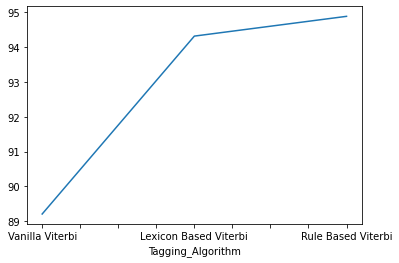

In [48]:
sample_test_data_acccuracy_df.plot.line(rot = 0, legend = False)
plt.show()

#### Observation:  Lexicon Based Viterbi & Rule Based Viterbi 's accuracy are greater than Plain Vannila Viterbi's accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [49]:
# A dataframe showing - 
# 1. words as tagged by vanilla viterbi
# 2. words as tagged by viterbi_for_lexicon_based - METHOD - 1
# 3. words as tagged by viterbi_for_rule_based - METHOD - 2

cols1 = ['as_tagged_by_vanilla_viterbi', 'as_tagged_by_Viterbi_Lexicon_Based','as_tagged_by_Viterbi_rule_Based'
            ]

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)


# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in vannila_test_tagged_seq]

# tags by Vanilla_Viterbi_for_Rule_Based - METHOD - 1
tags_comparison_df.as_tagged_by_Viterbi_rule_Based= [tup for tup in rulebased_test_tagged_seq]

# tags by Vanilla_Viterbi_for_Lexicon_Based  - METHOD - 2
tags_comparison_df.as_tagged_by_Viterbi_Lexicon_Based = [tup for tup in 
                                                                            lexicon_test_tagged_seq]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Viterbi_rule_Based]

as_tagged_by_vanilla_viterbi as_tagged_by_Viterbi_Lexicon_Based  \
0                 (Android, ADJ)                    (Android, NOUN)   
8                  (Google, ADJ)                     (Google, NOUN)   
10                (Android, ADJ)                    (Android, NOUN)   
15                     (OS, ADJ)                         (OS, NOUN)   
16              (worldwide, ADJ)                  (worldwide, NOUN)   
18            (smartphones, ADJ)                (smartphones, NOUN)   
20                   (2011, ADJ)                       (2011, NOUN)   
25                   (2013, ADJ)                       (2013, NOUN)   
27                 (Google, ADJ)                     (Google, NOUN)   
29                (Twitter, ADJ)                    (Twitter, NOUN)   
34                   (2015, ADJ)                       (2015, NOUN)   
37                 (Google, ADJ)                     (Google, NOUN)   
40                (Twitter, ADJ)                    (Twitter, NOUN)   
42               (firehose, ADJ)                   (firehose, NOUN)   
44                (Twitter, ADJ)                    (Twitter, NOUN)   
47                 (online, ADJ)                     (online, NOUN)   
58               (interact, ADJ)                   (interact, NOUN)   
60               (messages, ADJ)                   (messages, NOUN)   
63                 (tweets, ADJ)                     (tweets, NOUN)   
73            (domineering, ADJ)                (domineering, NOUN)   
78            (personality, ADJ)                (personality, NOUN)   
81                   (2018, ADJ)                       (2018, NOUN)   
82                   (FIFA, ADJ)                       (FIFA, NOUN)   
84                    (Cup, ADJ)                        (Cup, NOUN)   
87                   (21st, ADJ)                       (21st, NOUN)   
88                   (FIFA, ADJ)                       (FIFA, NOUN)   
90                    (Cup, ADJ)                        (Cup, NOUN)   
95             (tournament, ADJ)                 (tournament, NOUN)   
96              (contested, ADJ)                  (contested, NOUN)   
107                   (Cup, ADJ)                        (Cup, NOUN)   
131                 (trips, ADJ)                      (trips, NOUN)   
163              (arriving, ADJ)                   (arriving, NOUN)   
168                  (NASA, ADJ)                       (NASA, NOUN)   
169               (invited, ADJ)                    (invited, NOUN)   
178              (ICESAT-2, ADJ)                   (ICESAT-2, NOUN)   
179             (Satellite, ADJ)                  (Satellite, NOUN)   

    as_tagged_by_Viterbi_rule_Based  
0                   (Android, NOUN)  
8                    (Google, NOUN)  
10                  (Android, NOUN)  
15                       (OS, NOUN)  
16                (worldwide, NOUN)  
18              (smartphones, VERB)  
20                      (2011, NUM)  
25                      (2013, NUM)  
27                   (Google, NOUN)  
29                  (Twitter, NOUN)  
34                      (2015, NUM)  
37                   (Google, NOUN)  
40                  (Twitter, NOUN)  
42                 (firehose, NOUN)  
44                  (Twitter, NOUN)  
47                   (online, NOUN)  
58                 (interact, NOUN)  
60                 (messages, VERB)  
63                   (tweets, NOUN)  
73              (domineering, VERB)  
78              (personality, NOUN)  
81                      (2018, NUM)  
82                     (FIFA, NOUN)  
84                      (Cup, NOUN)  
87                     (21st, NOUN)  
88                     (FIFA, NOUN)  
90                      (Cup, NOUN)  
95               (tournament, NOUN)  
96                (contested, VERB)  
107                     (Cup, NOUN)  
131                   (trips, NOUN)  
163                (arriving, VERB)  
168                    (NASA, NOUN)  
169                 (invited, VERB)  
178                (ICESAT-2, NOUN)  
179     

#### Observations:

- Words like 'Twitter', 'Android', 'Google' are properly tagged with 'NOUN' in modified Viterbi Algorithm
- Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun)
- Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' in Rule Based Tagging
- Words with integers or float are properly tagged as 'NUM' are properly tagged as NUM in rule based tagger
- In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers cannot able to tag them. And it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.

